In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.utils.data import sampler
import math

import torchvision.datasets as dset
import torchvision.transforms as T
from torch.nn import functional as F

In [2]:
NUM_TRAIN = 49000

# The torchvision.transforms package provides tools for preprocessing data
# and for performing data augmentation; here we set up a transform to
# preprocess the data by subtracting the mean RGB value and dividing by the
# standard deviation of each RGB value; we've hardcoded the mean and std.
transform = T.Compose([
                T.ToTensor(),
                T.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
            ])

# We set up a Dataset object for each split (train / val / test); Datasets load
# training examples one at a time, so we wrap each Dataset in a DataLoader which
# iterates through the Dataset and forms minibatches. We divide the CIFAR-10
# training set into train and val sets by passing a Sampler object to the
# DataLoader telling how it should sample from the underlying Dataset.
cifar10_train = dset.CIFAR10('../data/CIFAR10', train=True, download=True,
                             transform=transform)
loader_train = DataLoader(cifar10_train, batch_size=64, 
                          sampler=sampler.SubsetRandomSampler(range(NUM_TRAIN)))

cifar10_val = dset.CIFAR10('../data/CIFAR10', train=True, download=True,
                           transform=transform)
loader_val = DataLoader(cifar10_val, batch_size=64, 
                        sampler=sampler.SubsetRandomSampler(range(NUM_TRAIN, 50000)))

cifar10_test = dset.CIFAR10('./data/CIFAR10', train=False, download=True, 
                            transform=transform)
loader_test = DataLoader(cifar10_test, batch_size=64)


Extracting ../data/CIFAR10/cifar-10-python.tar.gz to ../data/CIFAR10
Files already downloaded and verified



Extracting ./data/CIFAR10/cifar-10-python.tar.gz to ./data/CIFAR10


In [3]:
USE_GPU = True
dtype = torch.float32 # We will be using float throughout this tutorial.

if USE_GPU and torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

# Constant to control how frequently we print train loss.
print_every = 100

In [4]:
def check_accuracy(loader, model):
    if loader.dataset.train:
        print('Checking accuracy on validation set')
    else:
        print('Checking accuracy on test set')   
    num_correct = 0
    num_samples = 0
    model.eval()  # set model to evaluation mode
    with torch.no_grad():
        for x, y in loader:
            x = x.to(device=device, dtype=dtype)  # move to device, e.g. GPU
            y = y.to(device=device, dtype=torch.long)
            scores = model(x)
            _, preds = scores.max(1)
            num_correct += (preds == y).sum()
            num_samples += preds.size(0)
        acc = float(num_correct) / num_samples
        print('Got %d / %d correct (%.2f)' % (num_correct, num_samples, 100 * acc))
    return acc

In [5]:
def train(model, optimizer, epochs=1, graph=True):
    """
    Train a model on CIFAR-10 using the PyTorch Module API.
    
    Inputs:
    - model: A PyTorch Module giving the model to train.
    - optimizer: An Optimizer object we will use to train the model
    - epochs: (Optional) A Python integer giving the number of epochs to train for
    
    Returns: Nothing, but prints model accuracies during training.
    """
    if graph:
              #initialize
              loss_value_array = np.zeros(0)
              accuracy_value_array = np.zeros(0)
              training_accuracy_value_array = np.zeros(0)
    model = model.to(device=device)  # move the model parameters to CPU/GPU
    for e in range(epochs):
        for t, (x, y) in enumerate(loader_train):
            model.train()  # put model to training mode
            x = x.to(device=device, dtype=dtype)  # move to device, e.g. GPU
            y = y.to(device=device, dtype=torch.long)
            scores = model(x)
            loss = F.cross_entropy(scores, y)
            loss_value_array = np.append(loss_value_array, loss.item())

            # Zero out all of the gradients for the variables which the optimizer
            # will update.
            optimizer.zero_grad()

            # This is the backwards pass: compute the gradient of the loss with
            # respect to each  parameter of the model.
            loss.backward()

            # Actually update the parameters of the model using the gradients
            # computed by the backwards pass.
            optimizer.step()

            if (t) % (print_every*7) == 0:
                loss_value = (t, loss.item())
                print('Iteration %d, loss = %.4f' % loss_value)
                accuracy_value = check_accuracy(loader_val, model)
                training_accuracy_value = check_accuracy(loader_train, model)
                if graph:
                  accuracy_value_array = np.append(accuracy_value_array, accuracy_value)
                  training_accuracy_value_array = np.append(training_accuracy_value_array, training_accuracy_value)
            
    if graph:
      return loss_value_array, accuracy_value_array, training_accuracy_value_array

In [6]:
import torch
import torch.nn as nn
import math

def fourier_encode(x, max_freq, num_bands = 4, base = 2):
    x = x.unsqueeze(-1)
    device, dtype, orig_x = x.device, x.dtype, x

    scales = torch.logspace(0., math.log(max_freq / 2) / math.log(base), num_bands, base = base, device = device, dtype = dtype)
    scales = scales[(*((None,) * (len(x.shape) - 1)), Ellipsis)]

    x = x * scales * math.pi
    x = torch.cat([x.sin(), x.cos()], dim=-1)
    x = torch.cat((x, orig_x), dim = -1)
    return x


class MultiHeadAttention(nn.Module):
    def __init__(self, query_dim, dim_head, num_heads=1, context_dim = None, dropout=0):
        super().__init__()
        layers = []
        embed_dim = dim_head * num_heads
        if context_dim is None:
            context_dim = query_dim

        self.H = num_heads
        self.E = embed_dim
        self.q_linear = nn.Linear(query_dim, embed_dim)
        self.k_linear = nn.Linear(context_dim, embed_dim)
        self.v_linear = nn.Linear(context_dim, embed_dim)
        self.o_linear = nn.Linear(embed_dim, query_dim)
        self.dropout = nn.Dropout(p=dropout)

    def forward(self, query, context = None, attn_mask=None):
        if context is None:
            context = query
        N, S, query_dim = query.shape
        N, T, context_dim = context.shape

        q = self.q_linear(query)
        k = self.k_linear(context)
        v = self.v_linear(context)
        q_split = q.view((N, S, self.H, int(self.E/self.H))).transpose(1, 2)
        k_split = k.view((N, T, self.H, int(self.E/self.H))).transpose(1, 2)
        v_split = v.view((N, T, self.H, int(self.E/self.H))).transpose(1, 2)
        a = torch.matmul(q_split, k_split.transpose(2, 3))/math.sqrt(self.E/self.H)
        if attn_mask is not None:
            a = a.masked_fill(~(attn_mask.type(torch.bool)), -math.inf)
        e = torch.nn.functional.softmax(a, dim=3)
        y = torch.matmul(e, v_split)
        output = self.o_linear(y.transpose(1, 2).reshape(N, S, self.E))
        return self.dropout(output)

class FeedForward(nn.Module):
    def __init__(self, dim, mult = 4, dropout = 0.):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(dim, dim * mult),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(dim * mult, dim)
        )

    def forward(self, x):
        return self.net(x)

class VisionPerceiver(nn.Module):
    def __init__(self, input_dim, max_freq = 8,
                 input_channels=3, depth=1,
                 num_latents=32, latent_dim=128,
                 cross_heads = 1, cross_dim_head = 8,
                 latent_heads = 2, latent_dim_head = 8,
                 num_classes = 10,
                 attn_dropout = 0., ff_dropout = 0.):

        super().__init__()

        self.num_latents = num_latents
        self.latent_dim = latent_dim
        self.max_freq = max_freq
        input_channels *= 9
        # perceiver stacks
        self.layers = nn.ModuleList([])
        for i in range(depth): # build each perceiver cell
            cell = nn.ModuleList([])
            # cross attention module
            cell.append(nn.LayerNorm(latent_dim))
            cell.append(nn.LayerNorm(input_dim * input_channels))
            cell.append(MultiHeadAttention(latent_dim, dim_head = cross_dim_head,
                                           num_heads = cross_heads, context_dim = input_channels,
                                           dropout = attn_dropout))
            # feed forward
            cell.append(nn.LayerNorm(latent_dim))
            cell.append(FeedForward(latent_dim, dropout = ff_dropout))

            # latent transformer
            cell.append(nn.LayerNorm(latent_dim))
            cell.append(MultiHeadAttention(latent_dim, dim_head = latent_dim_head,
                                           num_heads = latent_heads, dropout = attn_dropout))
            # feed forward
            cell.append(nn.LayerNorm(latent_dim))
            cell.append(FeedForward(latent_dim, dropout = ff_dropout))

            self.layers.append(cell)

        self.to_logits = nn.Sequential(
                            nn.LayerNorm(latent_dim),
                            nn.Linear(latent_dim, num_classes))

    def forward(self, data, attn_mask=None, latent_init = None, seed = None):
        # flatten
        N, C, H, W = data.shape
        data = data.view(N, C, -1).transpose(1, 2)

        # encoding
        data = fourier_encode(data, self.max_freq)

        # determine the initial latent vector
        if latent_init is None:
            if seed is not None:
                torch.manual_seed(seed)
            latent_init = torch.randn(self.num_latents, self.latent_dim).unsqueeze(0).repeat([N, 1, 1])
            latent_init.requires_grad = False
        else:
            assert latent_init.shape == (num_latents, latent_dim)
            latent_init.unsqueeze(0).repeat([N, 1, 1])

        self.latent_init = nn.Parameter(latent_init)

        x = latent_init
        for cell in self.layers:
            # cross attention
            y = cell[1](data.reshape(N, -1))
            x = cell[2](cell[0](x), y.reshape(N, H*W, -1), attn_mask=attn_mask) + x
            # feed forward
            x = cell[4](cell[3](x)) + x
            # latent transformer
            x = cell[6](cell[5](x), attn_mask=attn_mask) + x
            # feed forward
            x = cell[8](cell[7](x)) + x

        x = x.mean(dim = -2)
        return self.to_logits(x)

In [7]:
import matplotlib.pyplot as plt

In [8]:
model = VisionPerceiver(1024, num_latents=64, attn_dropout=0.5, ff_dropout=0.8, depth=2, cross_heads=4, latent_dim_head=16, cross_dim_head=16, latent_heads=4)
optim = torch.optim.Adam(model.parameters(), lr=1e-3)
loss_value_array, accuracy_value_array, training_accuracy_value_array = train(model, optim, epochs = 5)

Iteration 0, loss = 2.5741
Checking accuracy on validation set
Got 106 / 1000 correct (10.60)
Checking accuracy on validation set
Got 5003 / 49000 correct (10.21)
Iteration 700, loss = 1.6385
Checking accuracy on validation set
Got 356 / 1000 correct (35.60)
Checking accuracy on validation set
Got 17509 / 49000 correct (35.73)
Iteration 0, loss = 1.5091
Checking accuracy on validation set
Got 362 / 1000 correct (36.20)
Checking accuracy on validation set
Got 18198 / 49000 correct (37.14)
Iteration 700, loss = 1.5915
Checking accuracy on validation set
Got 437 / 1000 correct (43.70)
Checking accuracy on validation set
Got 21251 / 49000 correct (43.37)
Iteration 0, loss = 1.5772
Checking accuracy on validation set
Got 442 / 1000 correct (44.20)
Checking accuracy on validation set
Got 21055 / 49000 correct (42.97)
Iteration 700, loss = 1.4855
Checking accuracy on validation set
Got 454 / 1000 correct (45.40)
Checking accuracy on validation set
Got 22489 / 49000 correct (45.90)
Iteration 0

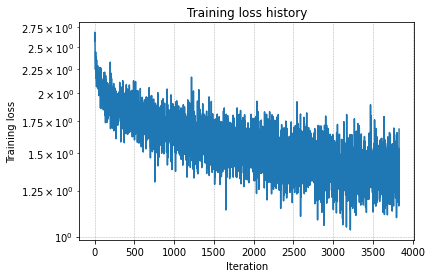

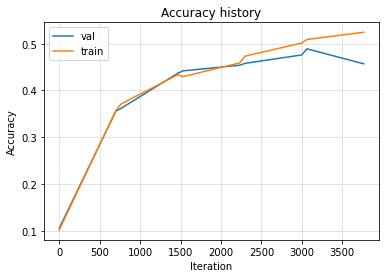

In [35]:
per_epcoh = len(loss_value_array)/5

base = np.array([0, 700])
base_array = np.zeros(0)

for i in range(5):
  
  base_array = np.append(base_array, base)
  base = base+766
  
plt.plot(loss_value_array)
plt.title("Training loss history")
plt.xlabel("Iteration")
plt.ylabel("Training loss")
plt.yscale("log")
plt.grid(linestyle='--', linewidth=0.5)
plt.show()

plt.plot(base_array,accuracy_value_array, label='val')
plt.plot(base_array,training_accuracy_value_array, label='train')
plt.title("Accuracy history")
plt.legend()
plt.xlabel("Iteration")
plt.ylabel("Accuracy")
plt.grid(linestyle='--', linewidth=0.5)
plt.show()